In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from scipy.integrate import odeint
from scipy.spatial.distance import cdist

## Functions required

**BUILT THE NETWORK**

In [31]:
def hexagon_mask(x, y, radius):
    """
    Return True if the point (x, y) is within a hexagon of given radius
    """
    return np.abs(x) <= radius and np.abs(y) <= radius and np.abs(x + y) <= radius
    
def create_hexagonal_network(radius):
    """
    Return the hexagonal undirected network of given radius with triangular lattice
    """
    G = nx.Graph()
    # Create the triangular lattice
    for x in range(-radius, radius + 1):
        for y in range(-radius, radius + 1):
            if hexagon_mask(x, y, radius):
                # Add the node
                G.add_node((x, y))
                # Add edges to neighbors
                neighbors = [(x + 1, y), (x, y + 1), (x - 1, y + 1)]
                for nx_, ny_ in neighbors:
                    if hexagon_mask(nx_, ny_, radius):
                        G.add_edge((x, y), (nx_, ny_))
                        #G.add_edge((nx_, ny_), (x, y))
    return G

def cuadratic_mask(x, y, radius):
    """
    Return True if the point (x, y) is within a cuadratic of given radius
    """
    return np.abs(x) <= radius and np.abs(y) <= radius 

def create_cuadratic_network(radius):
    """
    Return the cuadratic undirected network of given radius
    """
    G = nx.Graph()
    # Create the cuadratic lattice
    for x in range(-radius, radius+1):
        for y in range(-radius, radius+1):
            if cuadratic_mask(x, y, radius):
                # Add the node
                G.add_node((x, y))
                # Add edges to neighbors
                neighbors = [(x + 1, y), (x, y + 1)]
                for nx_, ny_ in neighbors:
                    if cuadratic_mask(nx_, ny_, radius):
                        G.add_edge((x, y), (nx_, ny_))
    return G

In [ ]:
def get_nodes_from_edges(edge_list):
    """
    Receive as input a list of edges (2 tuples) and
    return a list of nodes (1 tuple) without repeating
    """
    node_list = set()
    for i in edge_list:
        for j in i:
            node_list.add(j)
    return list(node_list)

**GENERATING THE PATHS: RANDOMLY AND HOTSPOTS**

In [33]:
## Generate shortest paths given, randomly, an origin and a destination ##
def generate_random_paths(n_users, G):
    paths = []
    destination_array = []
    node_map = list(G)
    num_nodes = G.number_of_nodes()
    OD_matrix = np.zeros((len(node_map), len(node_map)))
    for j in range(n_users):
        # sample initial and final nodes uniformly at random
        origin_node_idx, destination_node_idx = np.random.randint(0, num_nodes, 2)
        if origin_node_idx == destination_node_idx:
            destination_node_idx = np.random.randint(0, num_nodes)
        origin_node = node_map[origin_node_idx]
        destination_node = node_map[destination_node_idx]
        OD_matrix[origin_node_idx, destination_node_idx] += 1
        path = nx.dijkstra_path(G, origin_node, destination_node)
        paths.append(path)
        destination_array.append(destination_node)
    return paths, OD_matrix, destination_array

## Generate the edges of the previous paths ## 
def edges_path(n_users, G):
    paths, _, destination_array = generate_random_paths(n_users, G)
    edges_paths = []
    for r in paths:
        route_edges = [(r[n], r[n+1]) for n in range(len(r)-1)]
        edges_paths.append(route_edges)
    return edges_paths, destination_array

## Generate shortest paths given, an origin and a destination considering hotspots ##
def generate_random_paths_hotspots(n_users, G, O_hotspots, D_hotspots):
    paths = []
    node_map = list(G)
    num_nodes = G.number_of_nodes()
    OD_matrix = np.zeros((len(node_map), len(node_map)))
    for _ in range(int(n_users/2)):
        origin_node_idx = np.random.poisson(np.random.choice(O_hotspots), 1)
        if origin_node_idx[0] >= num_nodes:
            origin_node_idx[0] = num_nodes-1
        destination_node_idx = np.random.poisson(np.random.choice(D_hotspots), 1)
        if destination_node_idx[0] >= num_nodes:
            destination_node_idx[0] = num_nodes-1
        origin_node = node_map[origin_node_idx[0]]
        destination_node = node_map[destination_node_idx[0]]
        OD_matrix[origin_node_idx, destination_node_idx] += 1
        path = nx.dijkstra_path(G, origin_node, destination_node)
        paths.append(path)
    for _ in range(int(n_users - len(paths))):
        origin_node_idx, destination_node_idx = np.random.randint(0, num_nodes, 2)
        if origin_node_idx == destination_node_idx:
            destination_node_idx = np.random.randint(0, num_nodes)
        origin_node = node_map[origin_node_idx]
        destination_node = node_map[destination_node_idx]
        OD_matrix[origin_node_idx, destination_node_idx] += 1
        path = nx.dijkstra_path(G, origin_node, destination_node)
        paths.append(path) 
    return paths, OD_matrix

## Generate the edges of the previous paths ## 
def edges_path_hotspots(n_users, G, O_hotspots, D_hotspots):
    paths, _ = generate_random_paths_hotspots(n_users, G, O_hotspots, D_hotspots)
    edges_paths = []
    for r in paths:
        route_edges = [(r[n], r[n+1]) for n in range(len(r)-1)]
        edges_paths.append(route_edges)
    return edges_paths

**COUNTING THE NUMBER OF USERS IN EVERY EDGE**

In [34]:
def count_transport_edge(paths):
    """
    Count the number of bikes and cars passing through an edge and 
    return a two tuples, one for bikes and other for cars, with the edge and number
    """
    tuple_counts = {}

    for i, path1 in enumerate(paths):
        for edge in path1:
            if edge not in tuple_counts:
                tuple_counts[edge] = 1
            for j, path2 in enumerate(paths):
                if i != j:
                    tuple_counts[edge] += path2.count(edge)
    
    return tuple_counts

**COMPUTING CONGESTION AND COSTS**

In [35]:
def congestion_points(paths, edge_capacity):
    """
    DETERMINE CONGESTION EDGES FOR BIKES AND CARS
    """ 

    # Count the number of users passing through each edge
    tuple_counts = count_transport_edge(paths)

    # Determine the congestion edges
    congestion_ratios = {}
    for i, j in enumerate(tuple_counts):
        congestion_ratio = list(tuple_counts.values())[i] / edge_capacity
        congestion_ratios[j] = congestion_ratio
    return congestion_ratios

def baseline_CT(mode_paths, t_block):
    """
    COMPUTE THE BASELINE COMMUTING TIME
    Considering that the velocity decreases linearly until reach the congestion
    """
    baselines = []
    for path in mode_paths:
        baseline = len(path) * t_block #t_block units (minutes)
        baselines.append(baseline)
    return baselines #minutes

def direct_CT(paths, congestion_ratio, penalty, rescaled=False):
    """
    COMPUTE THE DIRECT COMMUTING TIME
    congestion_ratio -> dictionary
    penalty -> give in seconds
    """ 
    if rescaled == True:
        max_cong_value = max(congestion_ratio.values())
        congestion_ratio = {key: ((value*1.25)/max_cong_value) for key, value in congestion_ratio.items()}

    congesttion_points = [key for key, value in congestion_ratio.items() if value > 0.8]
    congested_time = []
    for tuple in paths:
        c = 0
        for edge in tuple:
            #if edge in congesttion_points:
            c += penalty * congestion_ratio[edge] #sec
        congested_time.append(c/60) #minutes
    return congested_time #direct_cost in minutes

def direct_CT_RecomputingTime(paths, congestion_ratio, t_block, alpha=0.15, beta=4, rescaled=False):
    """
    congestion_ratio -> dictionary
    t_block -> give in minutes
    """
    if rescaled == True:
        max_cong_value = max(congestion_ratio.values())
        congestion_ratio = {key: ((value*1.25)/max_cong_value) for key, value in congestion_ratio.items()}

    new_times = {key: ((t_block*(1+alpha*(value)**beta)) - t_block) for key, value in congestion_ratio.items()} #t_block units (minutes)
    # Compute the time for each path
    direct = []
    for path in paths:
        c = 0
        for edge in path:
            c += new_times[edge]
        direct.append(c) 
    return direct # minutes

def indirect_CT(paths, congestion_ratio, penalty=0.1, rescaled=False):
    """
    COMPUTE THE INDIRECT COMMUTING TIME
    """
    if rescaled == True:
        max_cong_value = max(congestion_ratio.values())
        congestion_ratio = {key: ((value*1.25)/max_cong_value) for key, value in congestion_ratio.items()}

    indirect = []
    for tuple in paths:
        c = 0
        for edge in tuple:
            if (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] < 0.6):
                c += 0 * penalty #sec
            elif (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] < 0.7):
                c += 1 * penalty #sec
            elif (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] < 0.8):
                c += 2 * penalty #sec
            elif (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] < 0.9):
                c += 3 * penalty #sec
            elif (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] < 1.0):
                c += 4 * penalty #sec
            elif (edge in list(congestion_ratio.keys())) and (congestion_ratio[edge] > 1.0):
                c += 5 * penalty #sec
            else:
                continue
        indirect.append(c/60)
    return indirect #minutes

def parking_CT(destination_array, park_nodes):
    parking_CT = 0
    distance_to_park = []
    for i in destination_array:
        for j in park_nodes:
            if i not in park_nodes:
                distance = nx.shortest_path_length(G, source=i, target=j)
                distance_to_park.append(distance)

    distance_to_park = np.array(distance_to_park).reshape(int(len(distance_to_park)/len(park_nodes)), len(park_nodes))
    for k in distance_to_park:
        parking_CT += min(k)*5
    parking_CT = parking_CT/len(destination_array)

    return parking_CT

**REPLICATOR EQUATION**

In [36]:
###   FUNCTIONS FOR COMPUTING THE STABLE AND OPTIMAL POINTS   ###
def find_minimum_mean_commuting_time():
    D = M[0][0] - M[0][1] - M[1][0] + M[1][1]
    E = B_0[0] - B_0[1] + N*M[0][1] + N*M[1][0] - 2*N*M[1][1]
    F = N*B_0[1] + (N**2)*M[1][1]
    r_star = -E/(2*D)
    return [r_star, N-r_star]

In [37]:
###   SUPPORTING FUNCTIONS   ###
def mean_commuting_time(x):
    """
    Compute the average commuting time of the system
        Output: a scalar
    """
    mu = (1/N) * (np.dot(x.T, B_0) + np.dot(x.T, np.dot(M, x)))
    return mu

def commuting_time_vec(x):
    """
    Compute the commuting time of the system
        Output: a vector
    """
    return (B_0 + (M @ x))

def convert_mins_to_days(x):
    """
    Take an array in minutes as input 
    and return an array in days.
    """
    return x/(60*24)

def convert_days_to_mins(x):
    return x*(24*60)

###   FUNCTIONS TO DETERMINE THE DYNAMICS   ###
def replication_eq(x, t, rho):
    """
    Find the rate of change (derivative w.r.t. time)
    of a modal share. 
    """
    x = (x/np.sum(x))*N
    C = commuting_time_vec(x)
    mu = (1/N) * np.dot(C, x)
    x_dot = rho * x * (mu - C)
    return x_dot

def solve_replication_eq(x, t, rho):
    """
    Implement the replicator dynamics
    """
    xs = odeint(func=replication_eq, y0=x, t=t, args=(rho, ))
    return xs

**Define some constants**

In [38]:
average_speed_bike = 12 #km/h
average_speed_car = 30 #km/h
block_length = 0.1 #km

t_block_car = (block_length / average_speed_car)*60 #minutes
t_block_bike = (block_length / average_speed_bike)*60 #minutes

In [ ]:
car_length = 0.005 #km
distance_bt_cars = 0.003 #km
bike_length = 0.002 #km
distance_bt_bikes = 0.002 #km

edge_capacity_cars = block_length / (car_length + distance_bt_cars) #dimensionless
edge_capacity_bkes = block_length / (bike_length + distance_bt_bikes) #dimensionless

edge_capacity_cars_time = edge_capacity_cars * (60)  # in one hour
edge_capacity_bkes_time = edge_capacity_bkes * (60) # in one hour

## Triangular grid

In [40]:
# Define some parameters: the radius of the hexagon, number of people, number of parks and bike lanes
radius = 25
# Create and draw the hexagonal network
G = create_hexagonal_network(radius)

average_shortest_path_L = nx.average_shortest_path_length(G)
diameter_network = nx.diameter(G)
print("Length (diameter) of the city is", diameter_network*block_length, "km, the area is", np.round(((3*np.sqrt(3))/(2))*((radius*block_length)**2), 2), "km^2, and the number of users is", 2, ".")
print('Average shortest path length is', average_shortest_path_L*block_length,'km.')
print()
print('Baseline cost in minutes (path-independent):\t', [average_shortest_path_L*t_block_bike, average_shortest_path_L*t_block_car])

Length (diameter) of the city is 5.0 km, the area is 16.24 km^2, and the number of users is 2 .
Average shortest path length is 2.3237109174782162 km.

Baseline cost in minutes (path-independent):	 [11.618554587391081, 4.6474218349564325]


**Parking spots**

In [13]:
n_parks = 400
n_parks_removed = 100
random_edges_park = random.sample(G.edges(), n_parks)
park_nodes = get_nodes_from_edges(random_edges_park)

/tmp/ipykernel_17428/318878801.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  random_edges_park = random.sample(G.edges(), n_parks)


### Random paths generation

In [ ]:
n_users = {'bikes':1700, 'cars':2300}
N = sum(n_users.values())
## Generate the edges of shortest paths given, randomly, an origin and a destination ##
np.random.seed(7)
bike_edges_paths, _ = edges_path(n_users['bikes'], G)
car_edges_paths, destination_array_car = edges_path(n_users['cars'], G)

#c_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
#c_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)

#print('max VoC for bikes:', max(c_ratio_bike.values()))
#print('max VoC for cars:', max(c_ratio_car.values()))

**Main body**

In [14]:
timesteps = 150
rho = 0.6
#new_users_bike = 225
#new_users_cars = 75

dynamics_vector_tri = [[n_users['bikes'], n_users['cars']]]
C_vec_0_tri = []
mu_vec_0_tri = []
mu_vec_optimal_0_tri = []
stability_time = 0
for i in range(timesteps):
    congestion_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
    congestion_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)
    #parking_cost = parking_CT(destination_array_car, park_nodes)
    baseline_cost = [np.mean(baseline_CT(bike_edges_paths, t_block_bike)), np.mean(baseline_CT(car_edges_paths, t_block_car))]# + parking_cost]
    bike_congested_time = direct_CT(bike_edges_paths, congestion_ratio_bike, 0.1)
    car_congested_time = direct_CT(car_edges_paths, congestion_ratio_car, 0.5)
    direct_cost = [np.mean(bike_congested_time), np.mean(car_congested_time)]
    indirect_cost = [[0, np.mean(indirect_CT(car_edges_paths, congestion_ratio_bike, 0.1))], [np.mean(indirect_CT(bike_edges_paths, congestion_ratio_car, 0.1)), 0]]

    N = sum(n_users.values())
    x_0 = np.array([n_users['bikes'], n_users['cars']])
    B_0 = convert_mins_to_days(np.array(baseline_cost))    #days
    D_0 = convert_mins_to_days(np.diag(direct_cost))       #days
    I_0 = convert_mins_to_days(np.array(indirect_cost))    #days
    M = D_0 + I_0    

    C_0 = commuting_time_vec(x_0)
    C_vec_0_tri.append(C_0)
    mu_0 = mean_commuting_time(x_0)
    mu_vec_0_tri.append(mu_0)
    optimal_point = find_minimum_mean_commuting_time()
    mu_vec_optimal_0_tri.append(mean_commuting_time(np.array(optimal_point)))

    print(i, n_users, optimal_point)

    timepoints = np.arange(0, 2)
    x_vec = solve_replication_eq(x_0, timepoints, rho)
    dynamics_vector_tri.append(list(x_vec[-1]))

    bike_difference = int(int(np.round(x_vec[-1][0])) - n_users['bikes']) 
    ## bikes population are increasing --> move paths from cars to bikes
    if bike_difference > 0:
        car_congested_times = sorted(list(set(car_congested_time)), key = lambda x:float(x), reverse=True)
        car_path_congested_idx = []
        for i in car_congested_times:
            car_path_congested_idx_i = [index for index, value in enumerate(car_congested_time) if value == i]
            car_path_congested_idx += car_path_congested_idx_i
            if len(car_path_congested_idx) >= bike_difference:
                selected_paths_idx = random.sample(car_path_congested_idx, bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            bike_edges_paths.append(car_edges_paths[sel_pth])
            car_edges_paths.remove(car_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}        
    ## no population increasing
    elif bike_difference == 0:
        bike_edges_paths = bike_edges_paths
        car_edges_paths = car_edges_paths
        #stability_time += 1
        #if stability_time == 20:
            # Remove randomly some parking slots
            #parkings_to_remove = random.sample(park_nodes, n_parks_removed)
            #park_nodes = [item for item in park_nodes if item not in parkings_to_remove]
    #elif bike_difference == 0:      
    #    stability_time += 1
    #    if stability_time == 20:
    #        print('sub-optimal time:', np.round(mu_vec_0[-1]*24*60, 2), 'optimal time:', np.round(mu_vec_optimal_0[-1]*24*60, 2))
    #        new_bike_paths = edges_path(new_users_bike, G)
    #        new_car_paths = edges_path(new_users_cars, G)
    #        n_users = {'bikes':int(n_users['bikes'] + new_users_bike), 'cars':int(n_users['cars'] + new_users_cars)}
    #        bike_edges_paths = bike_edges_paths + new_bike_paths
    #        car_edges_paths = car_edges_paths + new_car_paths
    ## cars population are increasing --> more paths from bikes to cars
    else:
        bike_congested_times = sorted(set(bike_congested_time), key = lambda x:float(x), reverse=True)
        bike_path_congested_idx = []
        for i in bike_congested_times:
            bike_path_congested_idx_i = [index for index, value in enumerate(bike_congested_time) if value == i]
            bike_path_congested_idx += bike_path_congested_idx_i
            if len(bike_path_congested_idx) >= -bike_difference:
                selected_paths_idx = random.sample(bike_path_congested_idx, -bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            car_edges_paths.append(bike_edges_paths[sel_pth])
            bike_edges_paths.remove(bike_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}

0 {'bikes': 1700, 'cars': 2300} [3562.1882661871014, 437.81173381289864]
1 {'bikes': 1711, 'cars': 2289} [3530.460656796295, 469.5393432037049]
2 {'bikes': 1721, 'cars': 2279} [3501.641105125148, 498.358894874852]
3 {'bikes': 1731, 'cars': 2269} [3478.468735921997, 521.531264078003]
4 {'bikes': 1740, 'cars': 2260} [3454.691639489579, 545.3083605104212]
5 {'bikes': 1749, 'cars': 2251} [3429.5056889135635, 570.4943110864365]
6 {'bikes': 1757, 'cars': 2243} [3406.1628055778283, 593.8371944221717]
7 {'bikes': 1765, 'cars': 2235} [3383.748002362716, 616.2519976372841]
8 {'bikes': 1772, 'cars': 2228} [3366.241132311312, 633.758867688688]
9 {'bikes': 1779, 'cars': 2221} [3344.7507313166766, 655.2492686833234]
10 {'bikes': 1786, 'cars': 2214} [3326.3143594663266, 673.6856405336734]
11 {'bikes': 1793, 'cars': 2207} [3306.9715991207554, 693.0284008792446]
12 {'bikes': 1799, 'cars': 2201} [3289.2339347000816, 710.7660652999184]
13 {'bikes': 1805, 'cars': 2195} [3273.4459195438235, 726.55408045617

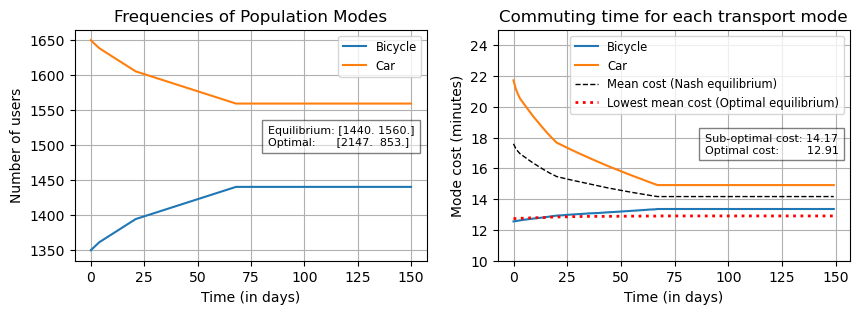

In [20]:
# n_users = {'bikes':1350, 'cars':1650}

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 1500, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].set_title("Commuting time for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 25)
ax[1].text(89, 17, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

plt.savefig('dynamics_triangularGrid_random_3000user.png')

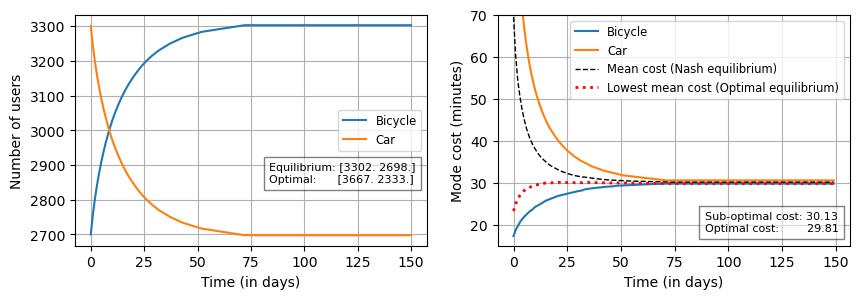

In [ ]:
#n_users = {'bikes':2700, 'cars':3300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
#ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 2850, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
#ax[1].set_title("Commuting time in minutes for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(15, 70)
ax[1].text(89, 18.5, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

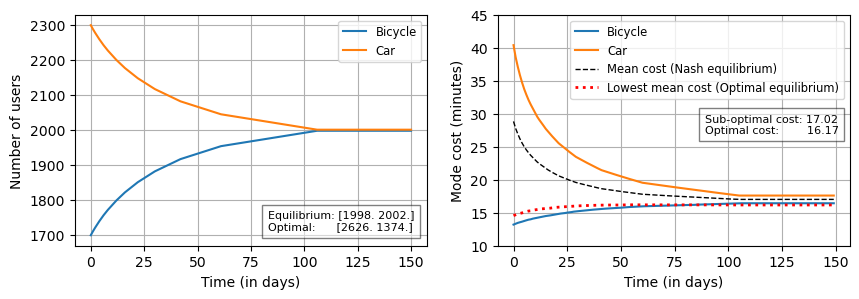

In [18]:
#{'bikes': 1700, 'cars': 2300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
#ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 1715, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
#ax[1].set_title("Commuting time in minutes for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 45)
ax[1].text(89, 27, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

plt.savefig('dynamics_triangularGrid_random_B1700C2300.png')

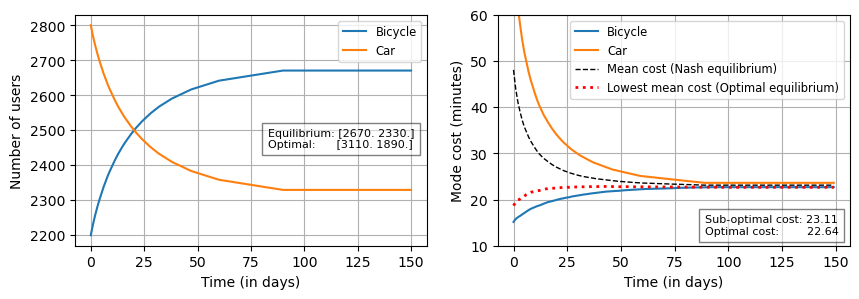

In [19]:
# n_users = {'bikes':2200, 'cars':2800}

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
#ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 2450, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
#ax[1].set_title("Commuting time for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 60)
ax[1].text(89, 12.5, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

plt.savefig('dynamics_triangularGrid_random_5000user.png')

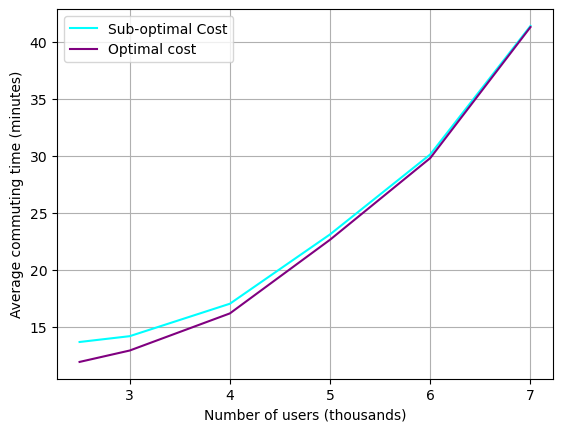

In [2]:
plt.plot([2.5, 3, 4, 5, 6, 7], [13.66, 14.17, 17.02, 23.11, 30.13, 41.41], color='cyan')
plt.plot([2.5, 3, 4, 5, 6, 7], [11.91, 12.91, 16.17, 22.64, 29.81, 41.31], color='purple')
plt.xlabel('Number of users (thousands)')
plt.ylabel('Average commuting time (minutes)')
plt.legend(['Sub-optimal Cost', 'Optimal cost'], loc='best')
plt.grid()

**Adding new users after equilibrium**

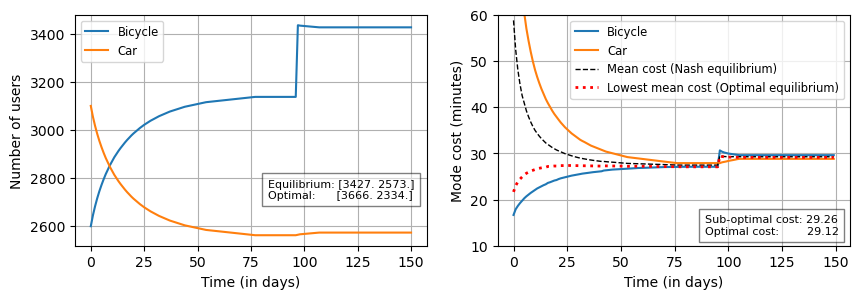

In [16]:
#n_users = {'bikes':2600, 'cars':3100}
#94 {'bikes': 3137, 'cars': 2563} [3529.118425253662, 2170.881574746338]
#95 {'bikes': 3137, 'cars': 2563} [3529.118425253662, 2170.881574746338]
#96 {'bikes': 3437, 'cars': 2563} [3569.951709626297, 2430.048290373703]
#97 {'bikes': 3435, 'cars': 2565} [3590.6967611584, 2409.3032388416]
#added 300 new bikes

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
#ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 2715, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
#ax[1].set_title("Commuting time in minutes for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 60)
ax[1].text(89, 12.5, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

plt.savefig('dynamics_triangularGrid_random_5700user+300bikes.png')

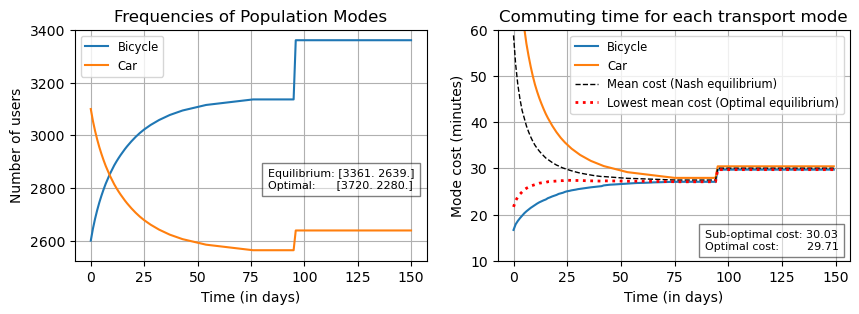

In [17]:
#n_users = {'bikes':2600, 'cars':3100}
#93 {'bikes': 3136, 'cars': 2564} [3532.0165654685316, 2167.9834345314684]
#94 {'bikes': 3136, 'cars': 2564} [3532.0165654685316, 2167.9834345314684]
#sub-optimal time: 27.46 optimal time: 27.09
#95 {'bikes': 3361, 'cars': 2639} [3719.6163388209143, 2280.3836611790857]
#96 {'bikes': 3361, 'cars': 2639} [3719.6163388209143, 2280.3836611790857]
#added 225 bikes and 75 cars

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 2800, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].set_title("Commuting time for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 60)
ax[1].text(89, 12.5, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

plt.savefig('dynamics_triangularGrid_random_5700user+225bikes+75cars.png')

### Paths generation with hotspots

In [41]:
#np.random.seed(7)
O_hotspots = np.random.randint(0, len(list(G)), 10)
D_hotspots = np.random.randint(0, len(list(G)), 10)

In [43]:
n_users = {'bikes':1700, 'cars':2300}
N = sum(n_users.values())
## Generate the edges of shortest paths given, randomly, an origin and a destination ##
np.random.seed(7)
bike_edges_paths = edges_path_hotspots(n_users['bikes'], G, O_hotspots, D_hotspots)
car_edges_paths = edges_path_hotspots(n_users['cars'], G, O_hotspots, D_hotspots)  

c_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
c_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)

print('max VoC for bikes:', max(c_ratio_bike.values()))
print('max VoC for cars:', max(c_ratio_car.values()))

max VoC for bikes: 0.662
max VoC for cars: 1.588


In [44]:
timesteps = 150
rho = 0.6

dynamics_vector = [[n_users['bikes'], n_users['cars']]]
C_vec_0 = []
mu_vec_0 = []
mu_vec_optimal_0 = []
stability_time = 0
for i in range(timesteps):
    congestion_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
    congestion_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)
    baseline_cost = [np.mean(baseline_CT(bike_edges_paths, t_block_bike)), np.mean(baseline_CT(car_edges_paths, t_block_car))]
    bike_congested_time = direct_CT(bike_edges_paths, congestion_ratio_bike, 0.1)
    car_congested_time = direct_CT(car_edges_paths, congestion_ratio_car, 0.5)
    direct_cost = [np.mean(bike_congested_time), np.mean(car_congested_time)]
    indirect_cost = [[0, np.mean(indirect_CT(car_edges_paths, congestion_ratio_bike, 0.1))], [np.mean(indirect_CT(bike_edges_paths, congestion_ratio_car, 0.1)), 0]]

    N = sum(n_users.values())
    x_0 = np.array([n_users['bikes'], n_users['cars']])
    B_0 = convert_mins_to_days(np.array(baseline_cost))    #days
    D_0 = convert_mins_to_days(np.diag(direct_cost))       #days
    I_0 = convert_mins_to_days(np.array(indirect_cost))    #days
    M = D_0 + I_0    

    C_0 = commuting_time_vec(x_0)
    C_vec_0.append(C_0)
    mu_0 = mean_commuting_time(x_0)
    mu_vec_0.append(mu_0)
    optimal_point = find_minimum_mean_commuting_time()
    mu_vec_optimal_0.append(mean_commuting_time(np.array(optimal_point)))

    print(i, n_users, optimal_point)

    timepoints = np.arange(0, 2)
    x_vec = solve_replication_eq(x_0, timepoints, rho)
    dynamics_vector.append(list(x_vec[-1]))

    bike_difference = int(int(np.round(x_vec[-1][0])) - n_users['bikes']) 
    ## bikes population are increasing --> move paths from cars to bikes
    if bike_difference > 0:
        car_congested_times = sorted(list(set(car_congested_time)), key = lambda x:float(x), reverse=True)
        car_path_congested_idx = []
        for i in car_congested_times:
            car_path_congested_idx_i = [index for index, value in enumerate(car_congested_time) if value == i]
            car_path_congested_idx += car_path_congested_idx_i
            if len(car_path_congested_idx) >= bike_difference:
                selected_paths_idx = random.sample(car_path_congested_idx, bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            bike_edges_paths.append(car_edges_paths[sel_pth])
            car_edges_paths.remove(car_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}        
    ## no population increasing
    elif bike_difference == 0:
        bike_edges_paths = bike_edges_paths
        car_edges_paths = car_edges_paths 
    ## cars population are increasing --> more paths from bikes to cars
    else:
        bike_congested_times = sorted(set(bike_congested_time), key = lambda x:float(x), reverse=True)
        bike_path_congested_idx = []
        for i in bike_congested_times:
            bike_path_congested_idx_i = [index for index, value in enumerate(bike_congested_time) if value == i]
            bike_path_congested_idx += bike_path_congested_idx_i
            if len(bike_path_congested_idx) >= -bike_difference:
                selected_paths_idx = random.sample(bike_path_congested_idx, -bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            car_edges_paths.append(bike_edges_paths[sel_pth])
            bike_edges_paths.remove(bike_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}

0 {'bikes': 1700, 'cars': 2300} [3914.749322174032, 85.25067782596807]
1 {'bikes': 1727, 'cars': 2273} [3601.6722387224763, 398.3277612775237]
2 {'bikes': 1747, 'cars': 2253} [3442.5399899206977, 557.4600100793023]
3 {'bikes': 1763, 'cars': 2237} [3371.0765734861307, 628.9234265138693]
4 {'bikes': 1777, 'cars': 2223} [3316.083905147358, 683.9160948526419]
5 {'bikes': 1789, 'cars': 2211} [3244.084509204324, 755.9154907956759]
6 {'bikes': 1800, 'cars': 2200} [3197.249176054055, 802.7508239459448]
7 {'bikes': 1810, 'cars': 2190} [3152.0869355059426, 847.9130644940574]
8 {'bikes': 1819, 'cars': 2181} [3112.3701677806534, 887.6298322193466]
9 {'bikes': 1827, 'cars': 2173} [3081.4647578759864, 918.5352421240136]
10 {'bikes': 1835, 'cars': 2165} [3047.307614341638, 952.6923856583621]
11 {'bikes': 1842, 'cars': 2158} [3019.27677762765, 980.7232223723499]
12 {'bikes': 1849, 'cars': 2151} [2989.9207380880107, 1010.0792619119893]
13 {'bikes': 1855, 'cars': 2145} [2961.1236328973023, 1038.87636710

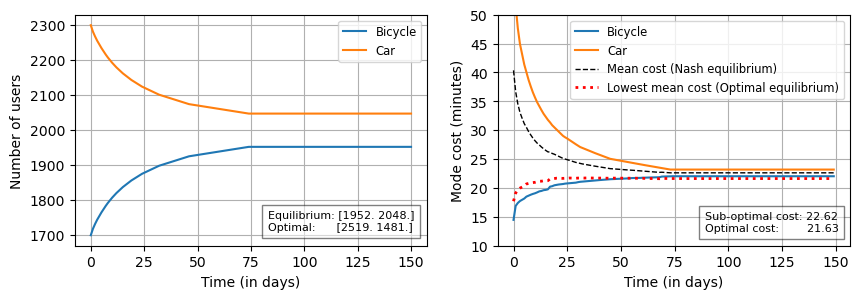

In [ ]:
#n_users = {'bikes':1700, 'cars':2300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
#ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83, 1715, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
#ax[1].set_title("Commuting time in minutes for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].set_ylim(10, 50)
ax[1].text(89, 12.5, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

#plt.savefig('dynamics_triangularGrid_hotspots.png')

## Rectangular grid

In [15]:
# Define some parameters: the radius of the hexagon, number of people, number of parks and bike lanes
radius = 20
# Create and draw the hexagonal network
D = create_cuadratic_network(radius)

average_shortest_path_L = nx.average_shortest_path_length(D)
diameter_network = nx.diameter(D)
print("Length (diameter) of the city is", diameter_network*block_length, "km, the area is", np.round((2*radius*block_length)**2, 2), "km^2, and the number of users is", 2000, ".")
print('Average shortest path length is', average_shortest_path_L*block_length,'km.')
print()
print('Baseline cost in minutes (path-independent):\t', [average_shortest_path_L*t_block_bike, average_shortest_path_L*t_block_car])

Length (diameter) of the city is 8.0 km, the area is 16.0 km^2, and the number of users is 2000 .
Average shortest path length is 2.7333333333333334 km.

Baseline cost in minutes (path-independent):	 [13.666666666666666, 5.466666666666667]


### Random paths generation

In [16]:
#n_users = {'bikes':700, 'cars':1300}
n_users = {'bikes':1700, 'cars':2300}
N = sum(n_users.values())
## Generate the edges of shortest paths given, randomly, an origin and a destination ##
np.random.seed(7)
bike_edges_paths, _ = edges_path(n_users['bikes'], D)
car_edges_paths, _ = edges_path(n_users['cars'], D)

c_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
c_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)

print('max VoC for bikes:', max(c_ratio_bike.values()))
print('max VoC for cars:', max(c_ratio_car.values()))

max VoC for bikes: 0.6206666666666667
max VoC for cars: 1.588


In [17]:
timesteps = 150
rho = 0.6

dynamics_vector_qua = [[n_users['bikes'], n_users['cars']]]
C_vec_0_qua = []
mu_vec_0_qua = []
mu_vec_optimal_0_qua = []
stability_time = 0
for i in range(timesteps):
    congestion_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
    congestion_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)
    baseline_cost = [np.mean(baseline_CT(bike_edges_paths, t_block_bike)), np.mean(baseline_CT(car_edges_paths, t_block_car))]
    bike_congested_time = direct_CT(bike_edges_paths, congestion_ratio_bike, 0.1)
    car_congested_time = direct_CT(car_edges_paths, congestion_ratio_car, 0.5)
    direct_cost = [np.mean(bike_congested_time), np.mean(car_congested_time)]
    indirect_cost = [[0, np.mean(indirect_CT(car_edges_paths, congestion_ratio_bike, 0.1))], [np.mean(indirect_CT(bike_edges_paths, congestion_ratio_car, 0.1)), 0]]

    N = sum(n_users.values())
    x_0 = np.array([n_users['bikes'], n_users['cars']])
    B_0 = convert_mins_to_days(np.array(baseline_cost))    #days
    D_0 = convert_mins_to_days(np.diag(direct_cost))       #days
    I_0 = convert_mins_to_days(np.array(indirect_cost))    #days
    M = D_0 + I_0    

    C_0 = commuting_time_vec(x_0)
    C_vec_0_qua.append(C_0)
    mu_0 = mean_commuting_time(x_0)
    mu_vec_0_qua.append(mu_0)
    optimal_point = find_minimum_mean_commuting_time()
    mu_vec_optimal_0_qua.append(mean_commuting_time(np.array(optimal_point)))

    print(i, n_users, optimal_point)

    timepoints = np.arange(0, 2)
    x_vec = solve_replication_eq(x_0, timepoints, rho)
    dynamics_vector_qua.append(list(x_vec[-1]))

    bike_difference = int(int(np.round(x_vec[-1][0])) - n_users['bikes']) 
    ## bikes population are increasing --> move paths from cars to bikes
    if bike_difference > 0:
        car_congested_times = sorted(list(set(car_congested_time)), key = lambda x:float(x), reverse=True)
        car_path_congested_idx = []
        for i in car_congested_times:
            car_path_congested_idx_i = [index for index, value in enumerate(car_congested_time) if value == i]
            car_path_congested_idx += car_path_congested_idx_i
            if len(car_path_congested_idx) >= bike_difference:
                selected_paths_idx = random.sample(car_path_congested_idx, bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            bike_edges_paths.append(car_edges_paths[sel_pth])
            car_edges_paths.remove(car_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}        
    ## no population increasing
    elif bike_difference == 0:
        bike_edges_paths = bike_edges_paths
        car_edges_paths = car_edges_paths 
    ## cars population are increasing --> more paths from bikes to cars
    else:
        bike_congested_times = sorted(set(bike_congested_time), key = lambda x:float(x), reverse=True)
        bike_path_congested_idx = []
        for i in bike_congested_times:
            bike_path_congested_idx_i = [index for index, value in enumerate(bike_congested_time) if value == i]
            bike_path_congested_idx += bike_path_congested_idx_i
            if len(bike_path_congested_idx) >= -bike_difference:
                selected_paths_idx = random.sample(bike_path_congested_idx, -bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            car_edges_paths.append(bike_edges_paths[sel_pth])
            bike_edges_paths.remove(bike_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}

0 {'bikes': 1700, 'cars': 2300} [4075.7825306197788, -75.78253061977875]
1 {'bikes': 1765, 'cars': 2235} [3610.077143053548, 389.92285694645216]
2 {'bikes': 1807, 'cars': 2193} [3466.2679799246575, 533.7320200753425]
3 {'bikes': 1840, 'cars': 2160} [3368.902797910787, 631.0972020892132]
4 {'bikes': 1867, 'cars': 2133} [3292.6128267708036, 707.3871732291964]
5 {'bikes': 1891, 'cars': 2109} [3228.088387752555, 771.9116122474452]
6 {'bikes': 1911, 'cars': 2089} [3176.816569153926, 823.1834308460739]
7 {'bikes': 1929, 'cars': 2071} [3123.0163647890395, 876.9836352109605]
8 {'bikes': 1945, 'cars': 2055} [3080.828739537776, 919.1712604622239]
9 {'bikes': 1959, 'cars': 2041} [3038.846515006794, 961.1534849932059]
10 {'bikes': 1971, 'cars': 2029} [3002.5469828811433, 997.4530171188567]
11 {'bikes': 1982, 'cars': 2018} [2966.1291283818514, 1033.8708716181486]
12 {'bikes': 1992, 'cars': 2008} [2935.074296276149, 1064.9257037238508]
13 {'bikes': 2001, 'cars': 1999} [2907.2713676780745, 1092.72863

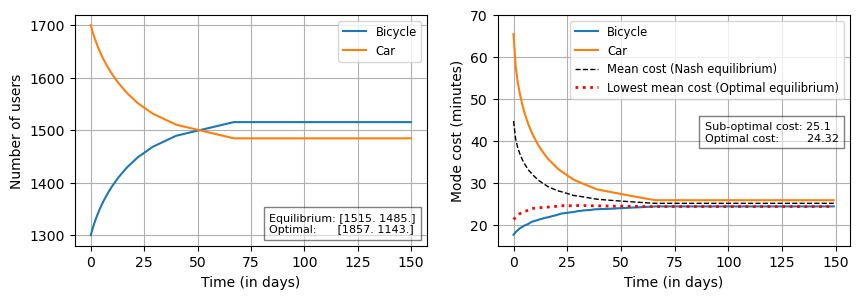

In [ ]:
#n_users = {'bikes':1700, 'cars':1300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 1305, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].text(89, 40, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].set_ylim(15, 70)
ax[1].grid()

plt.savefig('dynamics_cuadraticGrid_random_3000users.png')

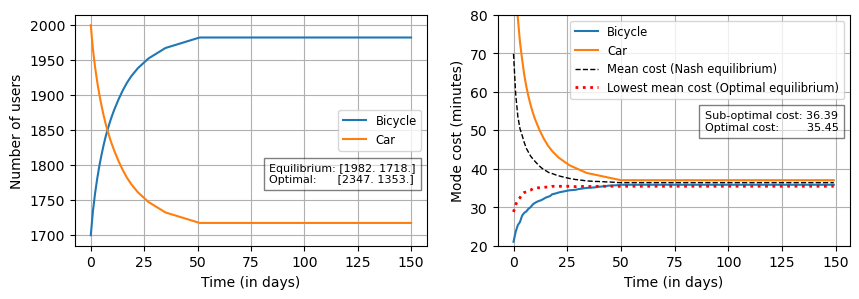

In [ ]:
#n_users = {'bikes':1700, 'cars':2000}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 1775, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].text(89, 50, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].set_ylim(20, 80)
ax[1].grid()

plt.savefig('dynamics_cuadraticGrid_random_B1700C2000.png')

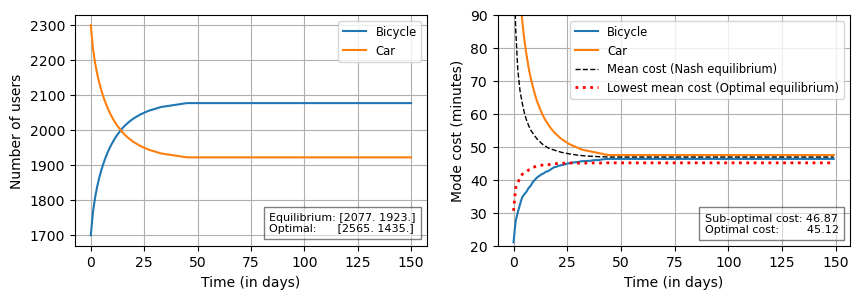

In [22]:
#n_users = {'bikes':1700, 'cars':2300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 1710, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].text(89, 24, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].set_ylim(20, 90)
ax[1].grid()

plt.savefig('dynamics_cuadraticGrid_random_B1700C2300.png')

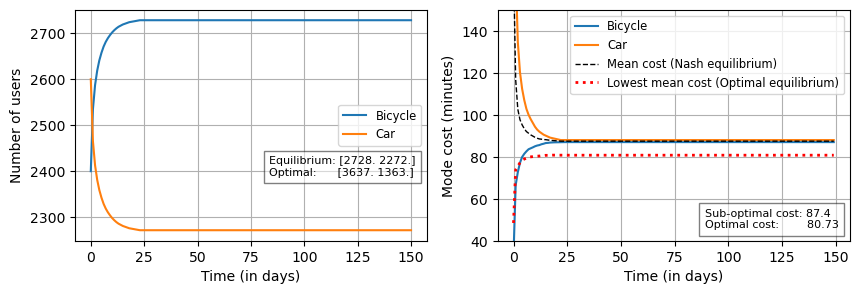

In [ ]:
#n_users = {'bikes':2400, 'cars':2600}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 2390, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].text(89, 46, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].set_ylim(40, 150)
ax[1].grid()

#plt.savefig('dynamics_cuadraticGrid_random_B1700C2300.png')

### Paths generation with hotspots

In [17]:
O_hotspots = np.random.randint(0, len(list(D)), 10)
D_hotspots = np.random.randint(0, len(list(D)), 10)

n_users = {'bikes':900, 'cars':1100}
#n_users = {'bikes':1700, 'cars':2300}
N = sum(n_users.values())
## Generate the edges of shortest paths given, randomly, an origin and a destination ##
np.random.seed(77)
bike_edges_paths = edges_path_hotspots(n_users['bikes'], D, O_hotspots, D_hotspots)
car_edges_paths = edges_path_hotspots(n_users['cars'], D, O_hotspots, D_hotspots)  

c_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
c_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)

print('max VoC for bikes:', max(c_ratio_bike.values()))
print('max VoC for cars:', max(c_ratio_car.values()))

max VoC for bikes: 0.662
max VoC for cars: 0.9373333333333334


In [18]:
timesteps = 150
rho = 0.6

dynamics_vector = [[n_users['bikes'], n_users['cars']]]
C_vec_0 = []
mu_vec_0 = []
mu_vec_optimal_0 = []
stability_time = 0
for i in range(timesteps):
    congestion_ratio_bike = congestion_points(bike_edges_paths, edge_capacity_bkes_time)
    congestion_ratio_car = congestion_points(car_edges_paths, edge_capacity_cars_time)
    baseline_cost = [np.mean(baseline_CT(bike_edges_paths, t_block_bike)), np.mean(baseline_CT(car_edges_paths, t_block_car))]
    bike_congested_time = direct_CT(bike_edges_paths, congestion_ratio_bike, 0.1)
    car_congested_time = direct_CT(car_edges_paths, congestion_ratio_car, 0.5)
    direct_cost = [np.mean(bike_congested_time), np.mean(car_congested_time)]
    indirect_cost = [[0, np.mean(indirect_CT(car_edges_paths, congestion_ratio_bike, 0.1))], [np.mean(indirect_CT(bike_edges_paths, congestion_ratio_car, 0.1)), 0]]

    N = sum(n_users.values())
    x_0 = np.array([n_users['bikes'], n_users['cars']])
    B_0 = convert_mins_to_days(np.array(baseline_cost))    #days
    D_0 = convert_mins_to_days(np.diag(direct_cost))       #days
    I_0 = convert_mins_to_days(np.array(indirect_cost))    #days
    M = D_0 + I_0    

    C_0 = commuting_time_vec(x_0)
    C_vec_0.append(C_0)
    mu_0 = mean_commuting_time(x_0)
    mu_vec_0.append(mu_0)
    optimal_point = find_minimum_mean_commuting_time()
    mu_vec_optimal_0.append(mean_commuting_time(np.array(optimal_point)))

    print(i, n_users, optimal_point)

    timepoints = np.arange(0, 2)
    x_vec = solve_replication_eq(x_0, timepoints, rho)
    dynamics_vector.append(list(x_vec[-1]))

    bike_difference = int(int(np.round(x_vec[-1][0])) - n_users['bikes']) 
    ## bikes population are increasing --> move paths from cars to bikes
    if bike_difference > 0:
        car_congested_times = sorted(list(set(car_congested_time)), key = lambda x:float(x), reverse=True)
        car_path_congested_idx = []
        for i in car_congested_times:
            car_path_congested_idx_i = [index for index, value in enumerate(car_congested_time) if value == i]
            car_path_congested_idx += car_path_congested_idx_i
            if len(car_path_congested_idx) >= bike_difference:
                selected_paths_idx = random.sample(car_path_congested_idx, bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            bike_edges_paths.append(car_edges_paths[sel_pth])
            car_edges_paths.remove(car_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}        
    ## no population increasing
    elif bike_difference == 0:
        bike_edges_paths = bike_edges_paths
        car_edges_paths = car_edges_paths 
    ## cars population are increasing --> more paths from bikes to cars
    else:
        bike_congested_times = sorted(set(bike_congested_time), key = lambda x:float(x), reverse=True)
        bike_path_congested_idx = []
        for i in bike_congested_times:
            bike_path_congested_idx_i = [index for index, value in enumerate(bike_congested_time) if value == i]
            bike_path_congested_idx += bike_path_congested_idx_i
            if len(bike_path_congested_idx) >= -bike_difference:
                selected_paths_idx = random.sample(bike_path_congested_idx, -bike_difference)
                selected_paths_idx.sort(reverse=True)
                break
        for sel_pth in selected_paths_idx:
            car_edges_paths.append(bike_edges_paths[sel_pth])
            bike_edges_paths.remove(bike_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}

0 {'bikes': 900, 'cars': 1100} [1753.783986660051, 246.2160133399491]
1 {'bikes': 904, 'cars': 1096} [1692.9738387666155, 307.0261612333845]
2 {'bikes': 908, 'cars': 1092} [1676.3594366975929, 323.64056330240714]
3 {'bikes': 911, 'cars': 1089} [1640.252233769556, 359.7477662304441]
4 {'bikes': 914, 'cars': 1086} [1624.4399945822354, 375.5600054177646]
5 {'bikes': 917, 'cars': 1083} [1605.9961875537997, 394.0038124462003]
6 {'bikes': 920, 'cars': 1080} [1591.8910592544594, 408.1089407455406]
7 {'bikes': 922, 'cars': 1078} [1578.9251712411976, 421.07482875880237]
8 {'bikes': 924, 'cars': 1076} [1568.9597033127989, 431.04029668720113]
9 {'bikes': 926, 'cars': 1074} [1560.9747900900845, 439.0252099099155]
10 {'bikes': 928, 'cars': 1072} [1551.3538346267392, 448.6461653732608]
11 {'bikes': 930, 'cars': 1070} [1543.3711142295047, 456.62888577049534]
12 {'bikes': 932, 'cars': 1068} [1534.8029189068316, 465.19708109316844]
13 {'bikes': 934, 'cars': 1066} [1525.3334166674695, 474.66658333253054

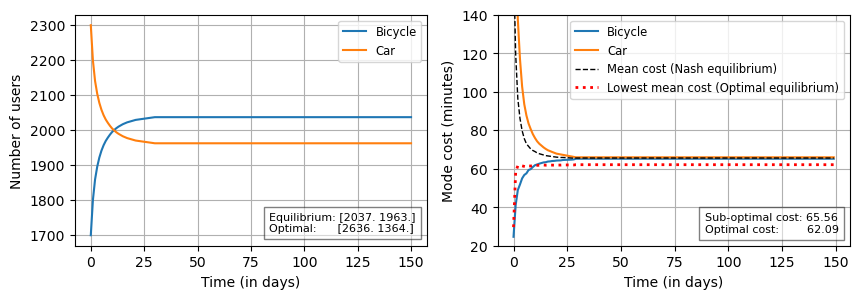

In [25]:
#n_users = {'bikes':1700, 'cars':2300}
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(83.5, 1710, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
ax[1].text(89, 27, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].set_ylim(20, 140)
ax[1].grid()

plt.savefig('dynamics_cuadraticGrid_hotspots_B1700C2300.png')